In [28]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from scipy.constants import pi, h, c, k
from pandas.api.types import CategoricalDtype
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column

h*=1e7 # Planck constant in erg*s
c*=1e2 # light speed in cm/s
k*=1e7 # Boltzmann constant in erg/K

def dprint(str,debug):
    
    '''
    Prints out all help text snippets where the debug flag is passed.
    '''
    
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    
    '''
    Displays additional information about a resulting 
    combo _opt_ of spectral classes given some colors 
    and approximates their likelihood by the mutual distance
    between the rows _d_. Conditional on the _debug_ flag being passed.
    '''
    
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    
    return

def spec_class_hist(specs,cluster,sort):

    counts = specs.spec_class.value_counts(sort=False)
    y = counts.sort_index()
    plot = y.plot(kind = 'bar',color='blue')
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/clean_CMD_{}.jpg'.format(cluster),dpi=300)
    return

def CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,kind = 'scatter', 
                      color=color_outlier_red(specs.index.values,outliers))
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}.jpg'.format(cluster,color),dpi=300)
    return

def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', 
                      color=color_outlier_red(specs.index.values,outliers)[0],
                      alpha=color_outlier_red(specs.index.values,outliers)[1],
                      s=list(specs['counts']) )
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    alpha = []
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
            alpha.append(0.3)
        else:
            color.append('black')
            alpha.append(1)
    #color = ['red' if val in outliers else 'black'
    return color, alpha


def interactive_CMD(specs,cid1='gmag',cid2='imag'):
    '''
    Simplistic tool to create an interactive 
    bokeh plot where outliers can be marked and saved in
    '/home/ekaterina/Documents/appaloosa/stars_shortlist/share/temp'
    '''
    # Create some random data and put it into a ColumnDataSource
    x = list(specs[cid1]-specs[cid2])
    y = list(specs[cid2])
    z = list(specs.index.values)
    source_data = ColumnDataSource(data=dict(x=x, y=y,desc=z))
    
    # Create a button that saves the coordinates of selected data points to a file
    savebutton = Button(label="Save", button_type="success")
    savebutton.callback = CustomJS(args=dict(source_data=source_data), code="""
            var inds = source_data.selected['1d'].indices;
            var data = source_data.data;
            var out = "";
            for (i = 0; i < inds.length; i++) {
                out += data['desc'][inds[i]] + " ";
            }
            var file = new Blob([out], {type: 'text/plain'});
            var elem = window.document.createElement('a');
            elem.href = window.URL.createObjectURL(file);
            elem.download = 'selected-data.txt';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """)

    # Plot the data and save the html file
    p = figure(plot_width=800, plot_height=400, 
               y_range=(16,7),
               tools="lasso_select, reset",)
    p.circle(x='x', y='y', source=source_data)
    p.xaxis.axis_label = '{}-{}'.format(cid1[0],cid2[0])
    p.yaxis.axis_label = cid1[0]
    plot = column(p, savebutton)
    output_file("test.html")
    show(plot)
    return

#----------------------------------------
#ENERGY CALC
#---------------------------------------

#Solution to nan-bug:
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return

#End: Solution to nan_bug

def spectrum(T, lib, wavmin=3480., wavmax=9700.):
    
    '''
    
    Returns the spectrum of a star at effective temperature T in wavelength range [wavmin,wavmax]
    Default range corresponds to Kepler response
    
    '''
    #loads library of spectra within wavelength range
    
    if T > 7000:
        print('{}K is hotter than 7000K.'.format(T))
        return lib.wav, []
    elif T < 3000:
        print('{}K is cooler than 3000K.'.format(T))
        return lib.wav, []
    else: 

        #find the spectrum that fits T best
        print('T=',T)
        Tmin = str(T-100.)
        Tmax = str(T+100.)
        cut = lib.library_params.query(Tmin+'<Teff<'+Tmax)
        #print('cut\n',cut.head())
        T_offer = zip(list(cut['Teff']), list(cut['lib_index']))
        T_minindex = min(T_offer, key = lambda t: abs(t[0]-T))[1]
        cut = cut.loc[T_minindex]
        #return the spectrum
        spec = lib.library_spectra[cut.lib_index,0,:]
        return lib.wav, spec.T

def kepler_spectrum(T,lib,deriv=False):
    '''
    
    Convolves a blackbody of effective temperature T, 
    the spectrum of a dwarf star with corresponding spectral class,
    and the Kepler response function 
    to return the wavelength dependent flux of that star per area
    
    Parameters:
    -----------
    T - effective temperatur in K
    
    Returns:
    --------
    Kp_flux in erg/cm*(cm**2)
    Kp_midwav in angström
    
    
    '''
    Kp = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/Kepler_response.txt',
                                  skiprows=9,
                                  header=None,
                                  delimiter='\t',
                                  names=['wav','resp'])
    Kp.wav = Kp.wav.astype(np.float)*10. #convert to angström for spectrum function
    #load the spectrum within a wavelength range that fits given T_eff best
    Spec_wav, Spec_flux = spectrum(T,lib,Kp.wav.min(),Kp.wav.max())
    #map Kepler response linearly into wavelengths given with the spectrum
    if Spec_flux == []:
        print('{}K is too hot or too cool for specmatch-emp.'.format(T))
        return [],[],[]
    else:
        Spec_flux = np.interp(Kp.wav,Spec_wav,Spec_flux)
        Kp_flux = np.empty(Kp.wav.shape[0]-1)
        Kp_midwav  = np.empty(Kp.wav.shape[0]-1)
        planck  = np.empty(Kp.wav.shape[0]-1)
        #calculate the flux of a star with given T_eff 
        #accounting for Kepler filter 
        #and the corresp. spectrum of that stellar type 
        try:
            for i, response in Kp.resp[:-1].iteritems():
                dlambda = (Kp.wav[i+1]-Kp.wav[i])*1e-8 #infin. element of wavelength in cm
                lambda_ = Kp.wav[i:i+2].mean()*1e-8 #wavelength in cm
                Kp_midwav[i] = lambda_
                if deriv == False:
                    planck[i] = 2. * h * c**2 / lambda_**5 / (np.exp( h * c / ( lambda_ * k * T ) ) - 1. )     
                elif deriv == True:
                    e_ = np.exp( h * c / ( lambda_ * k * T ) )
                    planck[i] = 2. * h**2 * c**3 / lambda_**6 / T**2 / k / (e_ - 1. )**2 * e_     
                Kp_flux[i] = Spec_flux[i] * response * planck[i]
        except IndexError:
            pass
        
        return Kp_midwav, Kp_flux, planck

def plot_kepler_spectrum(T):

    wav, flux, planck = kepler_spectrum(T,lib)
    
    Kp = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/Kepler_response.txt',
                                  skiprows=9,
                                  header=None,
                                  delimiter='\t',
                                  names=['wav','resp'])

    if flux == []:
        return print('No data for T = {}K'.format(T))
    else:
        plt.figure()
        plt.plot(wav*1e8, flux,color='green')
        plt.plot(wav*1e8, Kp.resp[:-1]*planck.max(),color='red')
        plt.plot(wav*1e8, planck,color='black')
        plt.show()  
    return

def kepler_luminosity(T,lib, error=False):
    
    '''
    Integrates the Kepler flux,
    multiplies by the area A=pi*(R**2),
    to obtain observed quiescent flux for an object
    
    Return:
    
    total Kepler luminosity in erg/s of a dwarf star with effective temperature T
    
    '''
    
    params=pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
    
    #calculate Kepler spectrum of a dwarf star with temperature T
    print(T)
    if error==False:
        wav, flux, _ = kepler_spectrum(T,lib)
    elif error==True:
        wav, flux, _ = kepler_spectrum(T,lib,deriv=True)
        
    if flux == []:
        return print('{}K is too hot or too cold'.format(T))
    else:
        #interpolate where nans occur
        interpolate_nan(wav)
        interpolate_nan(flux)

        #select the relevant columns from params
        radii_teff = params[['T','R_Rsun']]
        radii_teff.set_index('T',inplace=True)
        radius_cm = radii_teff.R_Rsun[T]*6.96342e10 #stellar radius in cm
        if error == False:
            return np.trapz(flux, wav) * pi * (radius_cm**2)
        elif error == True:
            return np.trapz(flux, wav) * pi * (radius_cm**2)
    
def Kp_to_Lum(df, dm, Kp='Kp'):
    df['Kp_abs'] = df[Kp]+dm
    #print(df.head())
    return

def Mbol_to_Lum(Mbol):
    
    '''
    Returns:
    --------
    Bolometric luminosity of a star with Mbol in erg/s.
    '''
    
    Lum_Sun = 3.84e33 #erg/s
    Mbol_Sun = 4.74 #mag
    return Lum_Sun * 10**( Mbol_Sun - Mbol )

#-------------------------------
#FFD
#-------------------------------

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(flux_gap)[start:stop+1]
    residual = flux - model
    ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
#    myloc = loc + '_my_flares.txt'
#     try:
#         myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
#     except OSError:
#         myflares = []

    appaflares = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    appaids = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    return myflares, appaflares, appaids

def write_flares(forf,cluster, test, EPIC, typ='flares'):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares.csv'.format(loc,EPIC))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 



def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed = ED(row['istart_no_sys_no_thruster'],row['istop_no_sys_no_thruster'],flux.time,flux.flux_model,flux.flux_gap)
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges

def merged_spec_class(params):
    p = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
    colors = {'g_r':('gmag','rmag'),
              'r_i':('rmag','imag'),
              'i_z':('imag','zmag'),
              'z_J':('zmag','J'),
              'J_H':('J','H'),
              'H_K':('H','K'),
              'i-z':('imag','zmag'),
              'z-Y':('zmag','ymag'),
              'J-H':('J','H'),
              'H-K':('H','K'),}
    p['T_err'] = Terr(p['T'])
    p['R_Rsun_err'] =0.2*p.R_Rsun
    for col in p.columns.values:
        params[col]=np.nan
    for i, s in params.iterrows():
        _ = np.array([((s[item[0]]-s[item[1]])-p[key]).abs().argmin() for key, item in colors.items()])
        idx = np.int(np.median(_[~np.isnan(_)]))    
        for col in p.columns.values:
            params[col][i]=p[col].iloc[idx]

    params = params.join(p.iloc[idx])    
    return params

DM = lambda x: 5.*np.log10(float(x))-5. 

def L_quieterr(L, R, Rerr, T, Terr,lib):
    R*=6.96342e10 #stellar radius in cm
    Rerr*=6.96342e10 #stellar radius error in cm
    t1 = np.abs(L/R)
    deriv_L = kepler_luminosity(T, lib, error=True)
    t2 = np.abs(deriv_L)
    print(t1,t2)
    return (t1 * Rerr)+ (t2 * Terr)

def Terr(Tseq):
    Terr = Tseq.rolling(window=3,center=True).std()
    Terr = Terr.fillna(100)
    print(Terr)
    return Terr

## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [29]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.100,136.]
               }

cluster = 'NGC_1647'
basics = cluster_dict[cluster]
test = 'run_01'
dm = DM(basics[4])
global dm
l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)

print(glob.glob(l))

# if glob.glob(l) != []:
specs = pd.read_csv(l, index_col='EPIC')
# else:
#params = pd.read_csv(l, index_col='EPIC')
#print(params.columns)
wavmin, wavmax = 3480., 9700.
#lib = specmatchemp.library.read_hdf(wavlim=[wavmin,wavmax])
specs = merged_spec_class(specs)
specs['L_quiet'] = np.nan
specs['L_quiet_bol'] = np.nan
specs['L_quiet_err'] =np.nan

print(specs.columns)
print(specs.head())
for oid in specs.index.values:
    specs.L_quiet_bol[oid] = Mbol_to_Lum(specs.Mbol[oid])
    specs.L_quiet[oid] = kepler_luminosity(specs['T'][oid],lib)
    specs.L_quiet_err[oid] = L_quieterr(specs.L_quiet[oid],
                                        specs.R_Rsun[oid],
                                        specs.R_Rsun_err[oid],
                                        specs['T'][oid],
                                        specs['T_err'][oid],
                                        lib)


specs[['T','L_quiet','L_quiet2']].sort_values(by='T').head()

['/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647/NGC_1647_parameter.csv']
0       100.000000
1      2291.287847
2      1500.000000
3      1258.305739
4      1365.039682
5      1276.714533
6      1167.618659
7      1040.833000
8      1040.833000
9      1040.833000
10      500.000000
11      500.000000
12     1607.275127
13     2753.785274
14     2291.287847
15     2787.471973
16     3044.667470
17     1808.314132
18      964.365076
19      680.685929
20     1101.514109
21      873.689495
22     1040.833000
23     1652.271164
24     1135.781669
25      513.160144
26      602.771377
27      431.895049
28      325.627599
29      285.014620
          ...     
86      112.398102
87      145.028733
88      135.030861
89      130.000000
90      120.138809
91      105.039675
92       90.184995
93       70.237692
94       55.075705
95       45.092498
96       35.118846
97       30.000000
98       35.118846
99       40.000000
100      35.118846
101      35.118846
102      40.000000


,T,L_quiet,L_quiet2
EPIC,,,
247166643,3410.0,6.484489e+29,6.484489e+29
247131381,3500.0,8.912156e+29,8.912156e+29
247159731,3500.0,8.912156e+29,8.912156e+29
247135437,3700.0,1.967146e+30,1.967146e+30
247158149,3800.0,2.744186e+30,2.744186e+30


In [25]:
specs.L_quiet_err/specs.L_quiet

EPIC
247134522    0.289780
247133675    0.226633
247131381    0.236046
247140208    0.213069
247152215    0.254903
247140140    0.289780
247144554    0.254903
247137318    0.301516
247135189    0.255359
247142250    0.292094
247146947    0.292094
247142909    0.292094
247140858    0.216873
247138835    0.226633
247144738    0.301516
247152702    0.302802
247135437    0.234271
247138301    0.301516
247136661    0.210494
247144273    0.255359
247148453    0.201302
247141048    0.301516
247137978    0.301516
247144482    0.201302
247142189    0.301516
247147971    0.225024
247144857    0.219428
247144760    0.301516
247147055    0.289780
247145590    0.217058
               ...   
247165313    0.218650
247164111    0.226633
247165305    0.219428
247164503    0.213069
247173226    0.203857
247157742    0.225024
247171135    0.301516
247164884    0.302802
247172423    0.219428
247171017    0.301516
247159731    0.236046
247156683    0.217058
247162918    0.292094
247158149    0.238703
24716

In [20]:
crs = {'g_i':('gmag','imag'),
       'J_K':('J','K'),
       'r_z':('rmag','zmag'),
       'g_z':('gmag','zmag'),}

for key, c in crs.items():
    print(c[0],c[1])
    interactive_CMD(specs,cid1=c[0],cid2=c[1])
    input('Plot for {} done?'.format(key))

gmag imag


KeyboardInterrupt: 

In [ ]:
outs=pd.Series()
import os
for i in [1,2,3,4]:
    file = '/home/ekaterina/Documents/appaloosa/stars_shortlist/share/temp/selected-data{}.txt'.format(i)
    if os.stat(file).st_size != 0:
        df = pd.read_csv(file,header=None,sep=' ').T.dropna(how='any')
        df = df.rename(index=str, columns={0:'outlier'})
        df.outlier = df.outlier.astype('int')
        s = df.outlier
        outs = pd.concat([outs,s],ignore_index=True)
outs = outs.drop_duplicates()
print(outs)
for key, c in crs.items():
    CMD(specs,cluster,cid1=c[0],cid2=c[1],color=key,ylim=(19,5),outliers=outs)
outs.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_outliers.csv'.format(cluster))

In [ ]:
print(specs.shape)
specs = specs.drop(list(outs))
print(specs.shape)

In [ ]:
specs = specs.dropna(how='any',subset=['T','L_quiet'])

In [6]:
print(specs.shape)

(82, 62)


In [21]:
#intermediate save
specs.to_csv(l)

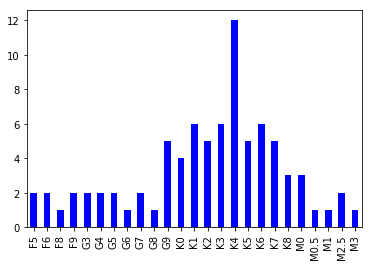

In [22]:
categor = ['{}{}'.format(c,num) for c in list('OBAFGKM') for num in list(range(10))]
type_ = CategoricalDtype(categories=categor, ordered=True)
specs.spec_class.astype(type_)
s = specs.sort_values(by='spec_class')
spec_class_hist(s,cluster,type_)

In [26]:
#remove all objects with spectral class hotter than F4
specs = specs[specs.spec_class > 'F3']
specs.shape
specs.to_csv(l)

In [ ]:
CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(21,8))#19,5
CMD(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(18,6))#14,5
CMD(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(20,8))#18,5
CMD(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(20,9))#18,5

In [27]:

flarelist = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647/results/run_01/NGC_1647_run_01_flarelist.txt',
    delimiter='\t')
flarelist = flarelist[['Object ID ',' Number of Flares ']]
flarelist = flarelist.rename(index=str, columns= {'Object ID ':'EPIC',' Number of Flares ':'counts'})
flarelist = flarelist.set_index('EPIC')
specs = specs.join(flarelist, how='left')
print(specs.head())


           Unnamed: 0    gmag    rmag    imag     zmag     ymag       J  \
EPIC                                                                      
247134522        59.0  15.267  14.383  14.021      NaN      NaN  12.684   
247133675        57.0  14.072  13.353  13.063      NaN      NaN  11.891   
247131381        71.0     NaN     NaN     NaN  14.7060  14.4881  13.311   
247140208        56.0  11.482  11.106  10.969  10.8520  10.8210   9.994   
247152215        63.0  15.939  14.917  14.518  14.2434  14.0872  13.038   

                H       K  RAJ2000   ...      g_i  57.1   L_quiet_bol  \
EPIC                                 ...                                
247134522  12.238  12.122  71.1425   ...    1.246   NaN  1.459927e+32   
247133675  11.577  11.486  71.2450   ...    1.009   NaN  4.724232e+32   
247131381  12.673  12.489  71.2468   ...      NaN   NaN  2.422876e+29   
247140208   9.854   9.748  71.1308   ...    0.513   NaN  6.085990e+32   
247152215  12.550  12.373  71.1330  

In [ ]:
specs.counts

In [ ]:
CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(20,9))

In [ ]:
def energy(oid_list, cluster, test, specs):
    clusterenergy, clusterenergy_err = [], []
    for oid in oid_list:
        myflares, flux, flares = import_flares(cluster, test, oid)
        L_quiet = specs['L_quiet'].loc[oid]
        L_quiet_err = specs['L_quiet_err'].loc[oid]
        s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
        tmyed, tenergy = [],[]
        for i,row in s_s.iterrows():
            ed, ederr = ED(row['istart_no_sys_no_thruster'],
                           row['istop_no_sys_no_thruster'],
                           flux.time,flux.flux_model,flux.flux_gap, flux.error)
            energy_err = energyerr(ederr,)
            if (ed != 'nan') & (ed > 0):
                clusterenergy.append(np.log10(ed*L_quiet))
                clusterenergy_err.append(energy_err)
                tenergy.append(np.log10(ed*L_quiet))
                tenergy_err.append(energy_err)
                tmyed.append(ed)
            else:
                clusterenergy.append(np.nan)
                tenergy.append(np.nan)
                tmyed.append(np.nan)
        flares['myed'] = tmyed
        flares['myenerg'] = tenergy
        flares['myenerg_err'] = tenergy_err
        write_flares(flares, cluster, test, oid, typ='flares')
    return clusterenergy

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    return (ed * L_quiet_err) + (ederr * L_quiet) 

def FFD(oid, cluster, test, specs,color='red'):
    myflares, flux, flares = import_flares(cluster, test, oid)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))

def cum_hist_average(oid_list, cluster, test, specs):
    ED_, bins=[], 600
    for oid in oid_list:

        myflares, flux, flares = import_flares(cluster, test, oid)
        T = specs['T'].loc[oid]
        L_quiet = specs['L_quiet'].loc[oid]
        s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
        tmyed, tED_ = [],[]
        for i,row in s_s.iterrows():
            ed, ederr = ED(row['istart_no_sys_no_thruster'],
                    row['istop_no_sys_no_thruster'],
                    flux.time,flux.flux_model,flux.flux_gap, flux.error)
            if (ed != 'nan') & (ed >0):
                ED_.append(np.log10(ed*L_quiet))
                tED_.append(np.log10(ed*L_quiet))
                tmyed.append(ed)
            else:
                ED_.append(0)
                tED_.append(0)
                tmyed.append(0)
        flares['myed'] = tmyed
        flares['myenerg'] =tED_
    print(flares.head())
    hist, edges=np.histogram(ED_, bins=bins)
    hist = np.flip(np.cumsum(np.flip(hist/oid_list.shape[0],axis=0)),axis=0)
    return hist, edges

def FFD_average(specs, cluster, test, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',
                subset='class'):
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([i for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = '{}K - {}K, n={}'.format(Tmin,Tmax,len(select))
    left, right = 250, -160
    #select = specs[specs.spec_class.str.contains(class_)].index.values
    hist, edges = cum_hist_average(select, cluster, test, specs)
    binmids=[(x+edges[i])/2. for i,x in enumerate(edges[1:])]
    p,residuals, rank, singular_values, rcond= np.polyfit(x=binmids[left:right],y=np.log10(hist[left:right]),deg=1, full=True)
    print(p,residuals, rank, singular_values, rcond)
    plt.plot(binmids, p[0]*np.asarray(binmids)+p[1])
    plt.axvline(x=binmids[left])
    plt.axvline(x=binmids[right])
    plt.scatter(binmids,np.log10(hist),color=color,alpha=0.5,label=label)
    return p, left, right, binmids


plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
#FFD_average(specs, cluster, test,class_=['K','M'],color='orange')
#FFD_average(specs, cluster, test,class_=['G'],color='green')
#FFD_average(specs, cluster, test,class_=['F'],color='blue')
#c_ = ['K','M']
#c_ = 'G'
#c_ = 'F'
c_ = ['F','G','K','M']
p,left, right, binmids = FFD_average(specs, cluster, test,
                                     class_=list(c_),color='green',
                                     Tmin=5000,Tmax=7000,
                                     subset='temperature')
p,left, right, binmids = FFD_average(specs, cluster, test,
                                     class_=list(c_),color='red',
                                     Tmin=3000,Tmax=4000,
                                     subset='temperature')
#p,left, right, binmids = FFD_average(specs, cluster, test,
                    #                 class_=list(c_),color='orange',
                       #              Tmin=4000,Tmax=5000,
                    #                 subset='temperature')
plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
if c_==['']: c_='all'
elif type(c_) == list: c_ = ''.join(map(str, c_))
plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD_{2}.jpg'.format(cluster,test,c_))


In [ ]:

specs['247135437'].head()

In [ ]:
if c_==['']: c_='all'
elif type(c_) == list: c_ = ''.join(map(str, c_))
print(c_)
columns = ['run','cluster','class','alpha','beta','cut_left','cut_right']
d = dict(zip(columns,[[test], [cluster],[c_],[-p[0]], [p[1]],[binmids[left]],[binmids[right]]]))
#tab = pd.DataFrame(d)
#tab = tab[columns]
tab = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/compare_alpha.csv')#,index_col=0)
#print(tab)
#d = dict(zip(columns,[[test], [cluster],[c_],[-p[0]], [p[1]],[binmids[left]],[binmids[right]]]))
#tab = tab.append(pd.DataFrame(d))#,columns=columns)
#print(tab)
#tab.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/compare_alpha.csv')
tab

In [ ]:
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
cluster = 'M67'
info = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/tests.csv'.format(cluster))
class_ = 'FGKM'
r = tab[(tab['class'] == class_) & ((tab.run == 'run_06') | (tab.run == 'run_07') | (tab.run == 'run_04'))].sort_values(by='cluster')
plt.figure(figsize=(12,8))
plt.title('FFD power law fits to M67 and M44 for spectral class {}'.format(class_))

plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
cc = {'M44':'blue','M67':'red'}
x = np.arange(31,36,0.05)
for idx, row in r.iterrows():
    iid = int(row.run[5:])-1
    l = find_nearest(x,row.cut_left)
    r = find_nearest(x,row.cut_right)
    plt.plot(x[l:r], 
             -row.alpha*x[l:r]+row.beta, 
             label='{}, N1 = {}, N2 = {}, N3 = {}, {}'.format(row.cluster, info.N1.loc[iid], info.N2.loc[iid], info.N3.loc[iid], info.other.loc[iid]),
             color=cc[row.cluster], alpha = float(row.run[5:])/4)
plt.legend()
#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/fits_{}_{}_comparison.jpg'.format(cluster,class_,))


In [ ]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


piv = pd.pivot_table(tab, values='alpha', index=['class','run'], columns=['cluster'])#, aggfunc=np.sum)
piv['M44-M67']=piv.M44-piv.M67
piv.style.applymap(color_negative_red)